In [1]:
import numpy as np
from qiskit import IBMQ, QuantumCircuit, Aer, execute
from qiskit.quantum_info import Operator
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from qiskit.tools.jupyter import *

provider = IBMQ.load_account()
import warnings
warnings.filterwarnings('ignore')

In [2]:
def phase_oracle(n, indices_to_mark, name='Oracle'):
    qc = QuantumCircuit(n, name=name)
    oracle_matrix = np.identity(2**n) # decompose to unitary matrix
    for index_to_mark in indices_to_mark:
        oracle_matrix[index_to_mark, index_to_mark] = -1
    qc.unitary(Operator(oracle_matrix), range(n))
    return qc

In [3]:
def diffuser(n):
    qc = QuantumCircuit(n, name='Diff - "V"')
    qc.h(range(n))
    qc.append(phase_oracle(n,[0]), range(n))
    qc.h(range(n))
    return qc

In [4]:
def Grover(n, marked):
    qc = QuantumCircuit(n, n)
    x = int(np.round(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2))
    print(f'{n} qubits, basis state {marked} marked, {x} rounds')
    qc.h(range(n))
    for _ in range(x):
        qc.append(phase_oracle(n, marked), range(n))
        qc.append(diffuser(n), range(n))
    qc.measure(range(n), range(n))
    return qc

5 qubits, basis state [22] marked, 4 rounds


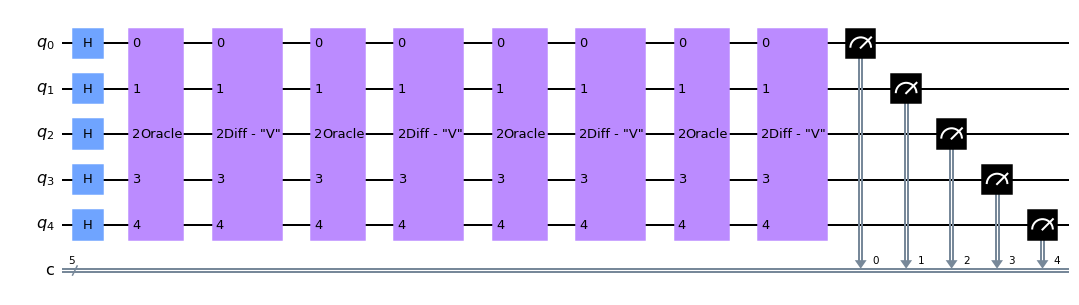

In [13]:
n = 5
x = np.random.randint(2**n)
marked = [x]
qc = Grover(n, marked)

qc.draw('mpl')

{'11010': 1, '00111': 1, '01110': 1, '01000': 1, '10111': 1, '00010': 1, '10011': 1, '11011': 1, '01011': 1, '11100': 1, '10110': 9990}
3.919534679768385


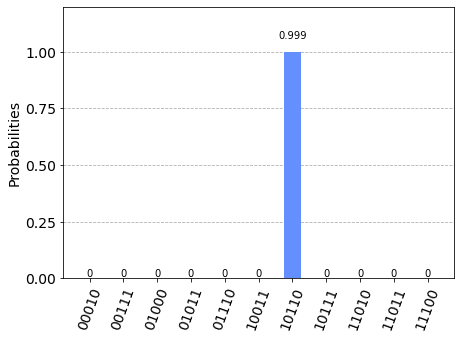

In [14]:
backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=10000).result()
counts = result.get_counts(qc)
print(counts)
print(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2)
plot_histogram(counts)
# small probabilities to measure the other elements -> in the 3rd step, after theta maybe below or to far
# from the expected w

In [15]:
def Grover_run_roundwise(n, marked):
    x = int(np.round(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2))
    print(f'{n} qubits, basis state {marked} marked, {x} rounds')
    counts = []
    for i in range(x):
        qc = QuantumCircuit(n, n)
        qc.h(range(n))
        for _ in range(i+1):
            qc.append(phase_oracle(n, marked), range(n))
            qc.append(diffuser(n), range(n))
        qc.measure(range(n), range(n))
        result = execute(qc, backend, shots = 10000).result()
        counts.append(result.get_counts(qc))
    return counts

5 qubits, basis state [22] marked, 4 rounds


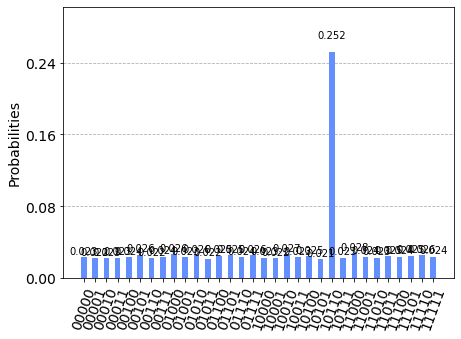

In [17]:
backend = Aer.get_backend('qasm_simulator')
counts = Grover_run_roundwise(n, marked)
plot_histogram(counts[0])

{'01011': 1, '11100': 1, '11000': 1, '10001': 1, '10011': 2, '10000': 2, '01000': 1, '10111': 1, '01110': 1, '01001': 1, '10110': 9988}


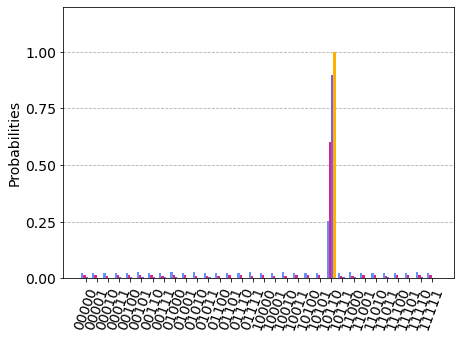

In [18]:
print(counts[3])
plot_histogram(counts, bar_labels=False)

In [20]:
n = 3
x = np.random.randint(2**n)
y = np.random.randint(2**n)
while y==x:
    y.np.random.randint(2**n) # why different marked element?
marked = [x,y]
qc = Grover(n, marked)

backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and
                                      not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)
%qiskit_job_watcher

shots = 1024
job = execute(qc, backend=backend, shots=shots, optimization_level=3)
print(job.job_id())

3 qubits, basis state [1, 2] marked, 1 rounds
least busy backend:  ibmq_belem


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

621501d20636282e932d8d09


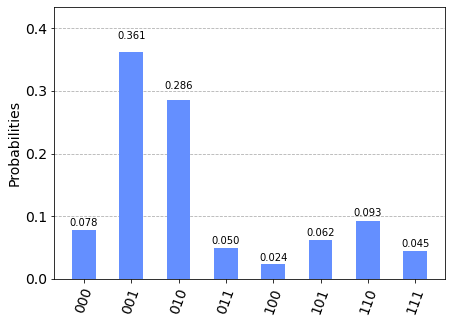

In [21]:
results = job.result()
answer = results.get_counts()
plot_histogram(answer)